In [26]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
%config InlineBackend.figure_format = 'retina'

# Extracting and transforming data:

**table_A_conversions.csv**:
* example list of conversions/ sales/ transaction
* Conv_ID - transaction ID
* Conv_Date - transaction date
* Revenue - value of transaction
* User_ID - an ID of a customer

**table_B_attribution.csv**:
* list of attribution results for conversions
* Conv_ID - transaction ID (link to table A)
* Channel - marketing channel
* IHC_Conv - attributed conversion fraction by the IHC model

table A extraction:

In [27]:
df_a = pd.read_csv('table_A_conversions.csv', sep=',', header=0)
df_a

,Conv_Date,Revenue,User_ID,Conv_ID
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735
...,...,...,...,...
79638,2018-03-26,165.96800,6836d8cdd9c6c537c702b35ccd972fae58070004,523b494fdc6f79c76762c434cee7854af824df9a
79639,2018-03-26,165.86000,bbc08d8abad5e699823f2f0021762797941679be,79a098aab7641fdea9499a91441a1aadf5212f6d
79640,2018-03-26,142.80000,39b5fdd28cb956053d3e4f3f0b884fb95749da8a,162bce00fb8455775c5a7819973023d0a03af934
79641,2018-03-26,231.56800,3342d5b210274b01e947cc15531ad53fbe25435b,ce7be68946baaf23c23bafffc0b60d63b9392615


Looking at how many null values are in the df_a:

In [28]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79643 entries, 0 to 79642
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Conv_Date  79643 non-null  object 
 1   Revenue    79643 non-null  float64
 2   User_ID    77347 non-null  object 
 3   Conv_ID    79643 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.4+ MB


A little bit more than 2000 recordings has NA values in User_ID column. For the analysis which includes aggregation by the users, I omit these values by making cleared df without null values, while for other analysis it is not important and the raw data could be used. 

Transforming the Conv_Date column to the datetime:

In [29]:
df_a.Conv_Date = pd.to_datetime(df_a.Conv_Date)

In [30]:
df_a.describe()

,Revenue
count,79643.000000
mean,181.695055
std,109.244220
min,20.000000
25%,114.232000
50%,158.470600
75%,217.592000
max,4596.476000


Number of unique users:

In [31]:
len(set(df_a.User_ID))

55353

Checking whether every row represent unique transactions ID in table A:

In [32]:
len(set(df_a.Conv_ID))

79643

Number of unique Conv_date records(the length of period considered in table A):

In [33]:
max(df_a.Conv_Date.values)

numpy.datetime64('2018-03-26T00:00:00.000000000')

table B:

In [34]:
df_b = pd.read_csv('table_B_attribution.csv', sep=',', header=0)
df_b

,Channel,IHC_Conv,Conv_ID
0,H,1.000000,881152bb20f9b73daafb99d77714f38ac702629c
1,I,0.300250,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,A,0.322839,faf5c1181ea84a32237dff45ca201d2c28f19d7b
3,E,0.376911,faf5c1181ea84a32237dff45ca201d2c28f19d7b
4,H,1.000000,b0e58a88459ece1b585ca22c93e633dc56273b83
...,...,...,...
211055,C,1.000000,ce7be68946baaf23c23bafffc0b60d63b9392615
211056,I,0.400014,2d94a2d0fc7408bb2210d012ba96d2a9949e4e45
211057,A,0.498988,2d94a2d0fc7408bb2210d012ba96d2a9949e4e45
211058,C,0.100998,2d94a2d0fc7408bb2210d012ba96d2a9949e4e45


Looking at how many null values are in the table B:

In [35]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211060 entries, 0 to 211059
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Channel   211060 non-null  object 
 1   IHC_Conv  211060 non-null  float64
 2   Conv_ID   211060 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.8+ MB


There is no null values in table, however number of observation in table B exceed number of observations in table A. 

Checking whether every row represents unique transactions ID in table(B):

In [36]:
len(set(df_b.Conv_ID))

79615

So there are some transactions, that comes from different Channels. And number of unique transactions is lower in table B(79615) than in table A(79643). 

# Merging the data

Merging the data in order to analyze all characteristics together. The table B unlike the table A is in the long format, that means that each row of the table B represents IHC_Conv value for some channel of the specific transaction ID.  Transforming it in the wide format, that each row represents each transactions ID. Unfortunately, pandas doesn't have built-in functions "long_to_wide"(only wide_to_long), so I write the function for such transformation:

In [37]:
def table_long_to_wide(table, index, columns, values):
    """Function transforming table from long to wide format
    
    Parameters
    ----------
    table : pandas.DataFrame
    index : list of strings
        Keys to group by on the pivot table index.
    columns : list of strings 
        Keys to group by on the pivot table column. 
    values : column to aggregate
    
    Rerturns
    ----------
    pandas.DataFrame
        table in a wide format
    """
    
    flatten_list_of_arguments = [item for sublist in [index, columns, values] 
                                 for item in sublist]
    
    # Checking whether each element of flatten list of arguments is string
    if not all(isinstance(elem, str) for elem in flatten_list_of_arguments):
        raise ValueError('values of list should be str')

    # Using pivot_table function from the pandas
    table = table.pivot_table(index=index, columns=columns, values=values)
    if isinstance(values, str):
        table.columns = [f"{values}_{y}" for y in table.columns]
    elif isinstance(values, list):
        table.columns = [f"{x}_{y}" for x, y in table.columns]
    
    table = table.reset_index()

    return table

In [38]:
df_b_wide = table_long_to_wide(df_b, index='Conv_ID', columns='Channel', values='IHC_Conv')
df_b_wide

,Conv_ID,IHC_Conv_A,IHC_Conv_B,IHC_Conv_C,IHC_Conv_D,IHC_Conv_E,IHC_Conv_F,IHC_Conv_G,IHC_Conv_H,IHC_Conv_I,IHC_Conv_J,IHC_Conv_K,IHC_Conv_L,IHC_Conv_M,IHC_Conv_N,IHC_Conv_O,IHC_Conv_P,IHC_Conv_Q,IHC_Conv_R,IHC_Conv_S,IHC_Conv_T,IHC_Conv_U,IHC_Conv_V
0,0000ccb093df86fd1480a0aa5c2167233f8ab9cf,0.540098,NaN,NaN,0.3786,NaN,NaN,0.081302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000ea3393004ed1e855e74f5eec5ad96270a816,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00011c4ee4c3484ebaf68d328668f9c97c5eaa4f,0.549969,0.450031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00015d1120d462a27b4a58b4e3b63b3831be28f8,0.323511,0.676489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00061879cf1e7229b4957a0d31723df0d5767cf3,0.910853,0.025606,0.039688,NaN,0.013145,NaN,0.007938,NaN,0.002770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79610,fffd439c7e1a4b1e48f8f3c317649053a17449dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79611,fffd619df698063561b25d1de5bf5fa874c08e6b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300231,NaN,0.399683,0.300086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79612,fffd8461f7a3efae355b357d32276789dd51acdd,0.610780,0.000000,NaN,NaN,0.133076,0.0,0.256144,0.00000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
79613,fffee612101cb4fe25dc8e2f01d0a8f6efb96c0d,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


According to the definition of IHC_Conv in a case study [«IHC-Attribution-Customer-Journey-Analytics»](https://haensel-ams.com/case-studies), IHC_Conv represents normalized value(totalling by all channels equals to 1) of the given conversion of the specific channel. So it will be convinient to substitute all NaN values(missing channels for the transaction) with 0.

In [39]:
df_b_wide = df_b_wide.fillna(0)
df_b_wide

,Conv_ID,IHC_Conv_A,IHC_Conv_B,IHC_Conv_C,IHC_Conv_D,IHC_Conv_E,IHC_Conv_F,IHC_Conv_G,IHC_Conv_H,IHC_Conv_I,IHC_Conv_J,IHC_Conv_K,IHC_Conv_L,IHC_Conv_M,IHC_Conv_N,IHC_Conv_O,IHC_Conv_P,IHC_Conv_Q,IHC_Conv_R,IHC_Conv_S,IHC_Conv_T,IHC_Conv_U,IHC_Conv_V
0,0000ccb093df86fd1480a0aa5c2167233f8ab9cf,0.540098,0.000000,0.000000,0.3786,0.000000,0.0,0.081302,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000ea3393004ed1e855e74f5eec5ad96270a816,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00011c4ee4c3484ebaf68d328668f9c97c5eaa4f,0.549969,0.450031,0.000000,0.0000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00015d1120d462a27b4a58b4e3b63b3831be28f8,0.323511,0.676489,0.000000,0.0000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00061879cf1e7229b4957a0d31723df0d5767cf3,0.910853,0.025606,0.039688,0.0000,0.013145,0.0,0.007938,0.00000,0.002770,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79610,fffd439c7e1a4b1e48f8f3c317649053a17449dc,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,1.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79611,fffd619df698063561b25d1de5bf5fa874c08e6b,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.00000,0.300231,0.0,0.399683,0.300086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79612,fffd8461f7a3efae355b357d32276789dd51acdd,0.610780,0.000000,0.000000,0.0000,0.133076,0.0,0.256144,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79613,fffee612101cb4fe25dc8e2f01d0a8f6efb96c0d,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merging table A and table B by column Conv_ID:

In [40]:
df = df_a.merge(df_b_wide, how='inner', on='Conv_ID')
# preventing from memory overflow during the session:
del df_a, df_b
df

,Conv_Date,Revenue,User_ID,Conv_ID,IHC_Conv_A,IHC_Conv_B,IHC_Conv_C,IHC_Conv_D,IHC_Conv_E,IHC_Conv_F,IHC_Conv_G,IHC_Conv_H,IHC_Conv_I,IHC_Conv_J,IHC_Conv_K,IHC_Conv_L,IHC_Conv_M,IHC_Conv_N,IHC_Conv_O,IHC_Conv_P,IHC_Conv_Q,IHC_Conv_R,IHC_Conv_S,IHC_Conv_T,IHC_Conv_U,IHC_Conv_V
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b,0.322839,0.000000,0.000000,0.0,0.376911,0.0,0.000000,0.000000,0.300250,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1,0.573316,0.024867,0.000000,0.0,0.020980,0.0,0.057023,0.146674,0.177042,0.0,0.000097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79610,2018-03-26,165.96800,6836d8cdd9c6c537c702b35ccd972fae58070004,523b494fdc6f79c76762c434cee7854af824df9a,0.518424,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.481576,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79611,2018-03-26,165.86000,bbc08d8abad5e699823f2f0021762797941679be,79a098aab7641fdea9499a91441a1aadf5212f6d,0.000000,0.549616,0.000000,0.0,0.000000,0.0,0.450384,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79612,2018-03-26,142.80000,39b5fdd28cb956053d3e4f3f0b884fb95749da8a,162bce00fb8455775c5a7819973023d0a03af934,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79613,2018-03-26,231.56800,3342d5b210274b01e947cc15531ad53fbe25435b,ce7be68946baaf23c23bafffc0b60d63b9392615,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df.to_csv('df_wide.csv')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79615 entries, 0 to 79614
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Conv_Date   79615 non-null  datetime64[ns]
 1   Revenue     79615 non-null  float64       
 2   User_ID     77319 non-null  object        
 3   Conv_ID     79615 non-null  object        
 4   IHC_Conv_A  79615 non-null  float64       
 5   IHC_Conv_B  79615 non-null  float64       
 6   IHC_Conv_C  79615 non-null  float64       
 7   IHC_Conv_D  79615 non-null  float64       
 8   IHC_Conv_E  79615 non-null  float64       
 9   IHC_Conv_F  79615 non-null  float64       
 10  IHC_Conv_G  79615 non-null  float64       
 11  IHC_Conv_H  79615 non-null  float64       
 12  IHC_Conv_I  79615 non-null  float64       
 13  IHC_Conv_J  79615 non-null  float64       
 14  IHC_Conv_K  79615 non-null  float64       
 15  IHC_Conv_L  79615 non-null  float64       
 16  IHC_Conv_M  79615 non-

We get 79615 rows in merged table, it means that every unique transaction in table B is in the table A. So, we can now interpret those missing transactions of the table A in transactions of table B: it is those transactions that come from unknown channels or from channels that are not listed in table B.  

# KPIs

Before further analysis, I determine the main goals and KPIs that stakeholders might be interesting for stakeholders. In the circumstances of this challenge, it's not possible to ask those stakeholders directly. In the list of hints to this challenge, there are several KPIs to consider is listed: **revenue, number customers, a fraction of return customer**. I add to this list another KPIs that stakeholders might be interested in depending on their goals:

**Market capture stratergy:**
* Number of customers
* Number of return customers
* Number of transactions

**Increasing of profitability/efficiency:**
* Revenue
* Number of days between  re-transactions(repeated)
* Effectivity of channels

**Customer Retention Strategy:**
* Increasing of loyalty
* Fraction of return customers

# Descriptive analytics

For this part of analysis, since a lot of descriptive statistics would be considred, it will be usefull to make a Class, that has such methods that show descriptive statistics in a convenient way.

In [43]:
class DescriptiveStatistics:
    """
    Class showing key descriptive statistics of a variable 
    grouped by another variable and plotting a histogram.

    ...

    Attributes
    ----------
    table : pd.DataFrame
    variable : str
    groupby : str
    agg : str
        aggregative function. 'sum' by default
    dropna : boolean
        if True NaN values will be droped from table. True by default
    
    Methods
    -------
    describe()
        returning descriptive statistics in a pandas.DataFrame format
    plot_histogram(ax=None)
        plotting a histogram of aggragaed variable

    """
    def __init__(self, table, variable, groupby, agg='sum', dropna=False):
        self.table = table
        self.variable = variable
        self.groupby = groupby
        self.dropna = dropna
        self.agg = agg
    
    def _aggregation(self):
        if self.dropna:
            gross_values= self.table.dropna().groupby(self.groupby).agg(self.agg)
        else:
            gross_values= self.table.groupby(self.groupby).agg(self.agg)
            
        values = gross_values[[self.variable]].values
        return values
        
    def describe(self):
        values = self._aggregation()
        mode = float(st.mode(values)[0])
        percentile_95 = np.percentile(values, 95) 
        mode_percentile = np.hstack([mode, percentile_95])
        descriptive_stat = np.hstack([scipy.stats.describe(values), 
                                      mode_percentile])
        descriptions = ['Number of observations', '[Minimum, Maximum]',
                        'Mean', 'Variance', 'Skewness', 'Kurtosis','Mode', 
                        '95% percentile']
        ziped = zip(descriptions, descriptive_stat)
        table_values = [[m, n] if isinstance(n, tuple) 
                        else [m, float(n)] for m, n in ziped]
        stats = pd.DataFrame(table_values, 
                             columns=['Characteristics',f'Desription of {self.agg}[{self.variable}] grouped by {self.groupby}'])
        return stats
    
    def plot_histogram(self, ax=None):
        """"
        Parameters
        ----------
        ax : matplotlib.pyplot.axes 
        """"
        values = self._aggregation()
        sns.distplot(values, bins=50, ax=ax)
        if ax:
            ax.set_xlabel(f"{self.agg}[{self.variable}]")
        else:
            plt.xlabel(f"{self.agg}[{self.variable}]")


In [44]:
def multiple_aggregation(table, variable, groupby, aggs):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    for i, agg in enumerate(aggs):
        A = DescriptiveStatistics(table, variable, groupby, agg)
        A.plot_histogram(ax.ravel()[i])
        if i > 0:
            tb = tb.merge(A.describe(), on='Characteristics')
        else:
            tb = A.describe()
    return tb

## Number of customers:

In [45]:
# total
n_customers = len(set(df.Conv_ID.values))
print('Total number of customers(excluding NaN User_ID) = ', n_customers)

Total number of customers(excluding NaN User_ID) =  79615


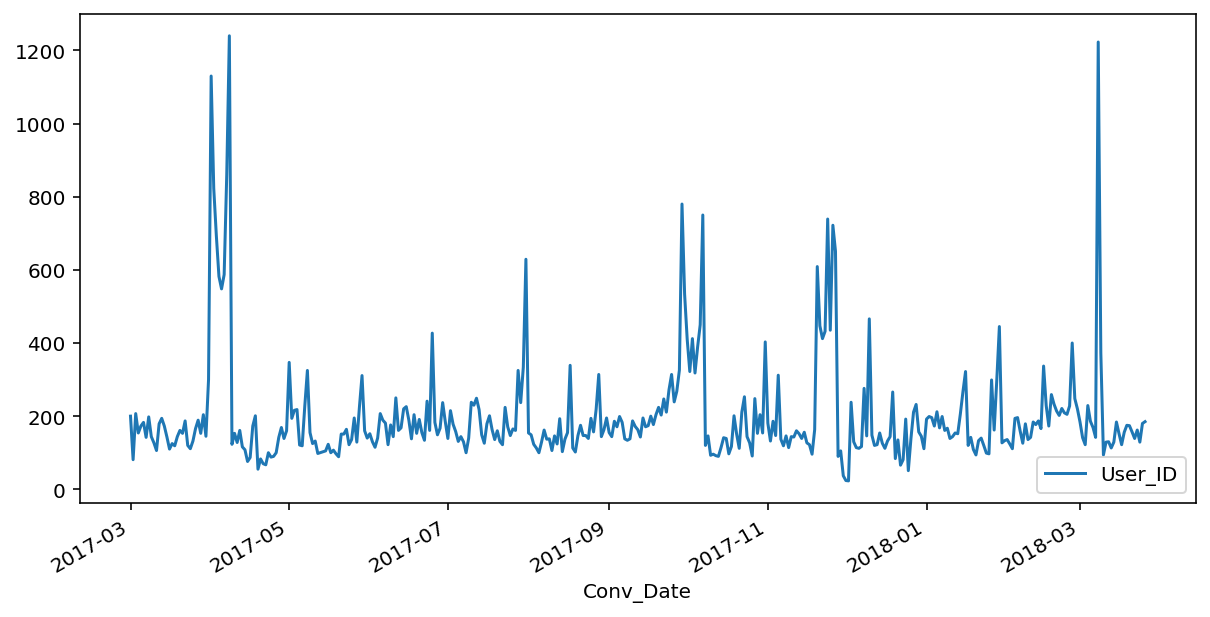

In [46]:
# over time
df.dropna().groupby('Conv_Date').agg('count')[['User_ID']].plot(kind='line', figsize=(10, 5))
plt.show()

## Number of return customers:

In [47]:
# total
n_return_customers = np.count_nonzero(df.dropna().groupby('User_ID').agg('count').Conv_ID.values > 1)
print('Total number of return customers(which made transaction more than once) = ', n_return_customers)

Total number of return customers(which made transaction more than once) =  8918


## Fraction of return customers:

In [49]:
# total
print('Fraction of return customers = ', n_return_customers/n_customers)

Fraction of return customers =  0.11201406770081015


In [50]:
# overtime
# df.dropna().group

## Revenue:

Looking at the Revenue aggregated using several aggregation function by User_ID:

,Characteristics,Desription of sum[Revenue] grouped by User_ID,Desription of min[Revenue] grouped by User_ID,Desription of max[Revenue] grouped by User_ID,Desription of mean[Revenue] grouped by User_ID
0,Number of observations,55332,55332,55332,55332
1,"[Minimum, Maximum]","([24.64696], [29117.303120000008])","([20.0], [2321.208])","([24.64696], [4596.476])","([24.64696], [2321.208])"
2,Mean,254.437,164.662,185.504,174.016
3,Variance,120127,8468.45,13352.9,9100.92
4,Skewness,17.409,2.89196,4.46746,2.77449
5,Kurtosis,1016.44,22.848,78.3077,20.979
6,Mode,112.42,112.42,100.42,112.42
7,95% percentile,742.822,328.728,386.255,342.112


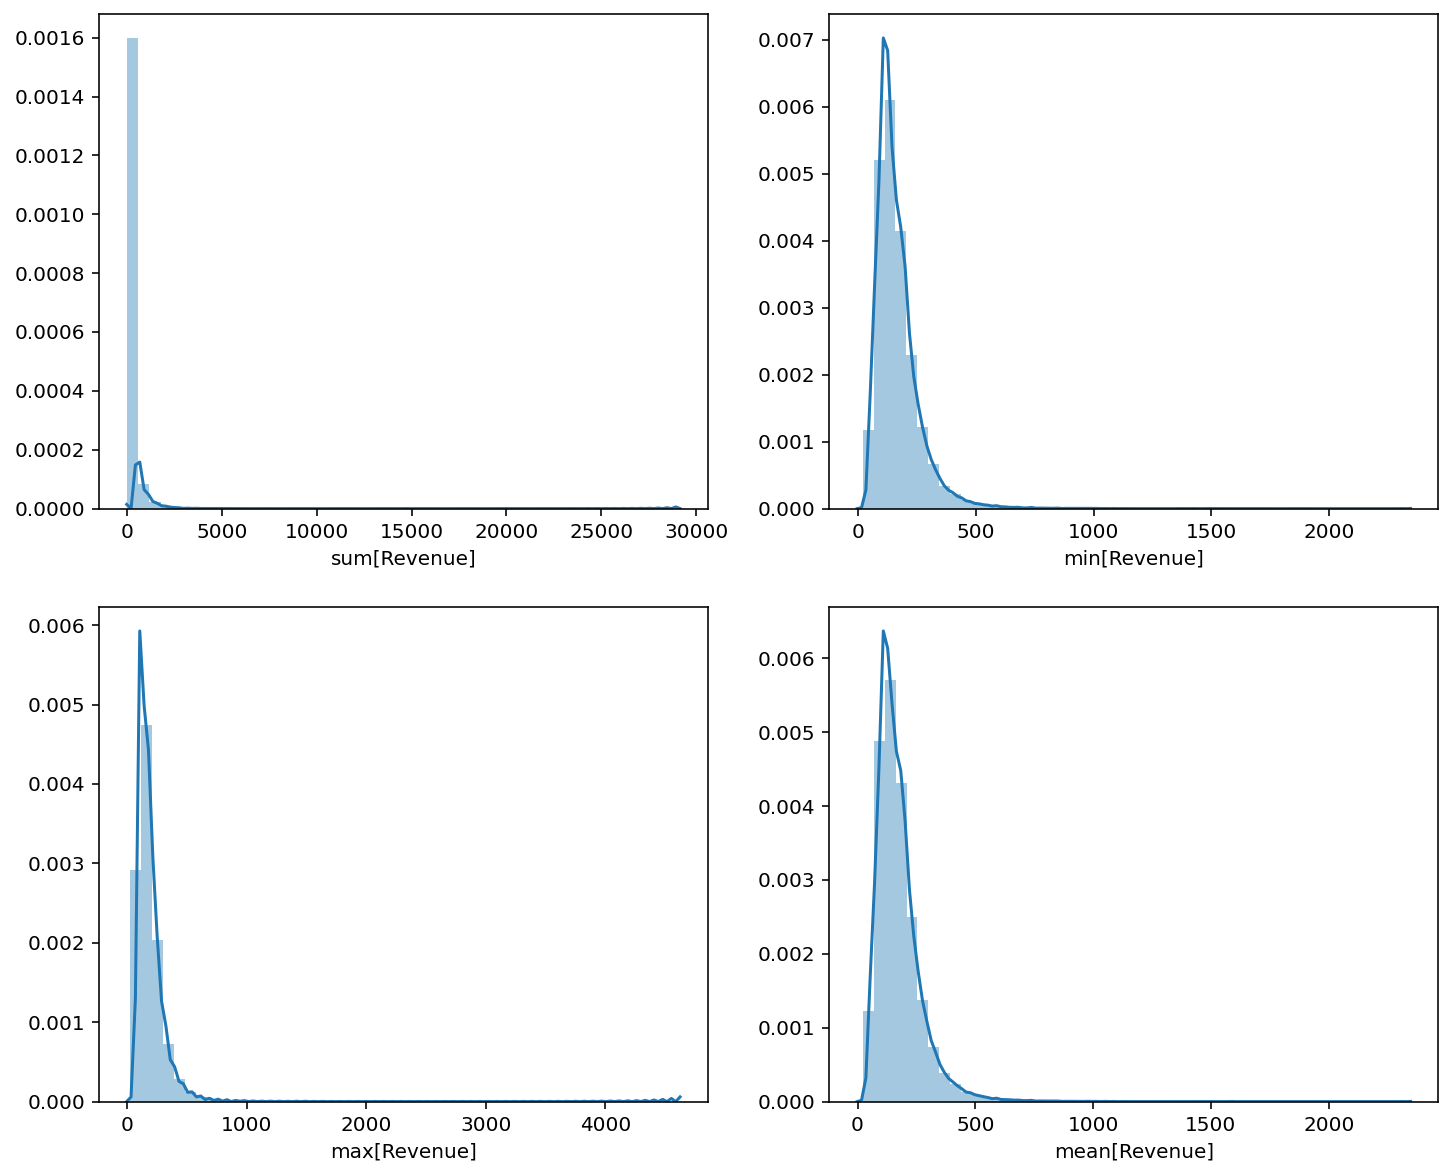

In [51]:
aggs = ['sum', 'min', 'max', 'mean']
multiple_aggregation(df, 'Revenue', 'User_ID', aggs)

As we can see from the table with descriptive statistics and histogram, aggregated revenue has interesting insights:
* Histograms of all aggregated values have very long tails, meaning that there are abnormal values(it could be seen from the plot, as well as that value of 95% percentile is too small compare to a max value significantly positioned in the right tail. 
* Empirical PDF skewed greatly to the right for each aggregated values(skewness >> 0) meaning that the majority of customers spends small sums of money(Mode < Mean). The probability mass distributed significantly on the right tail. In addition, we observe that skewness of sum[Revenue] is much higher compare to other aggregated values. It means that the most noticeable contribution in the distribution in the right tail is made mostly by returned customers. So, from the stakeholders perspective, it is better to try to have return customers(increase loyalty) than try to make the average sum of transaction bigger.
* Mean of the max '[Revenue]'(4596.476) is significantly lower than mean of the sum '[Revenue]'(29117.303), showing the difference between strategies aiming at increasing value of the transaction and increasing loyalty of clients(total of the revenue from return customers). 
* Kurtosis of the empirical PDF is much bigger than kurtosis of normal distribution(3), meaning that the peak of the ECDF is very sharp and therefore significant probability mass located in tails.

## Revenue of retrun customers:

Finding recordings in datatable df related to return customers(who did 2 or more transactions), which contains only return customers(customers with non-unique User_ID):

,Characteristics,Desription of sum[Revenue] grouped by User_ID,Desription of min[Revenue] grouped by User_ID,Desription of max[Revenue] grouped by User_ID,Desription of mean[Revenue] grouped by User_ID
0,Number of observations,8918,8918,8918,8918
1,"[Minimum, Maximum]","([76.588], [29117.303120000008])","([20.0], [874.816])","([42.663999999999994], [4596.476])","([38.294], [1575.1519999999998])"
2,Mean,697.828,140.822,270.133,198.857
3,Variance,463820,4684.87,27131.9,8551.35
4,Skewness,12.017,2.2021,5.51027,2.52007
5,Kurtosis,387.299,10.1453,92.305,14.973
6,Mode,434.312,113.504,182.816,75.148
7,95% percentile,1743.16,264.948,542.392,360.225


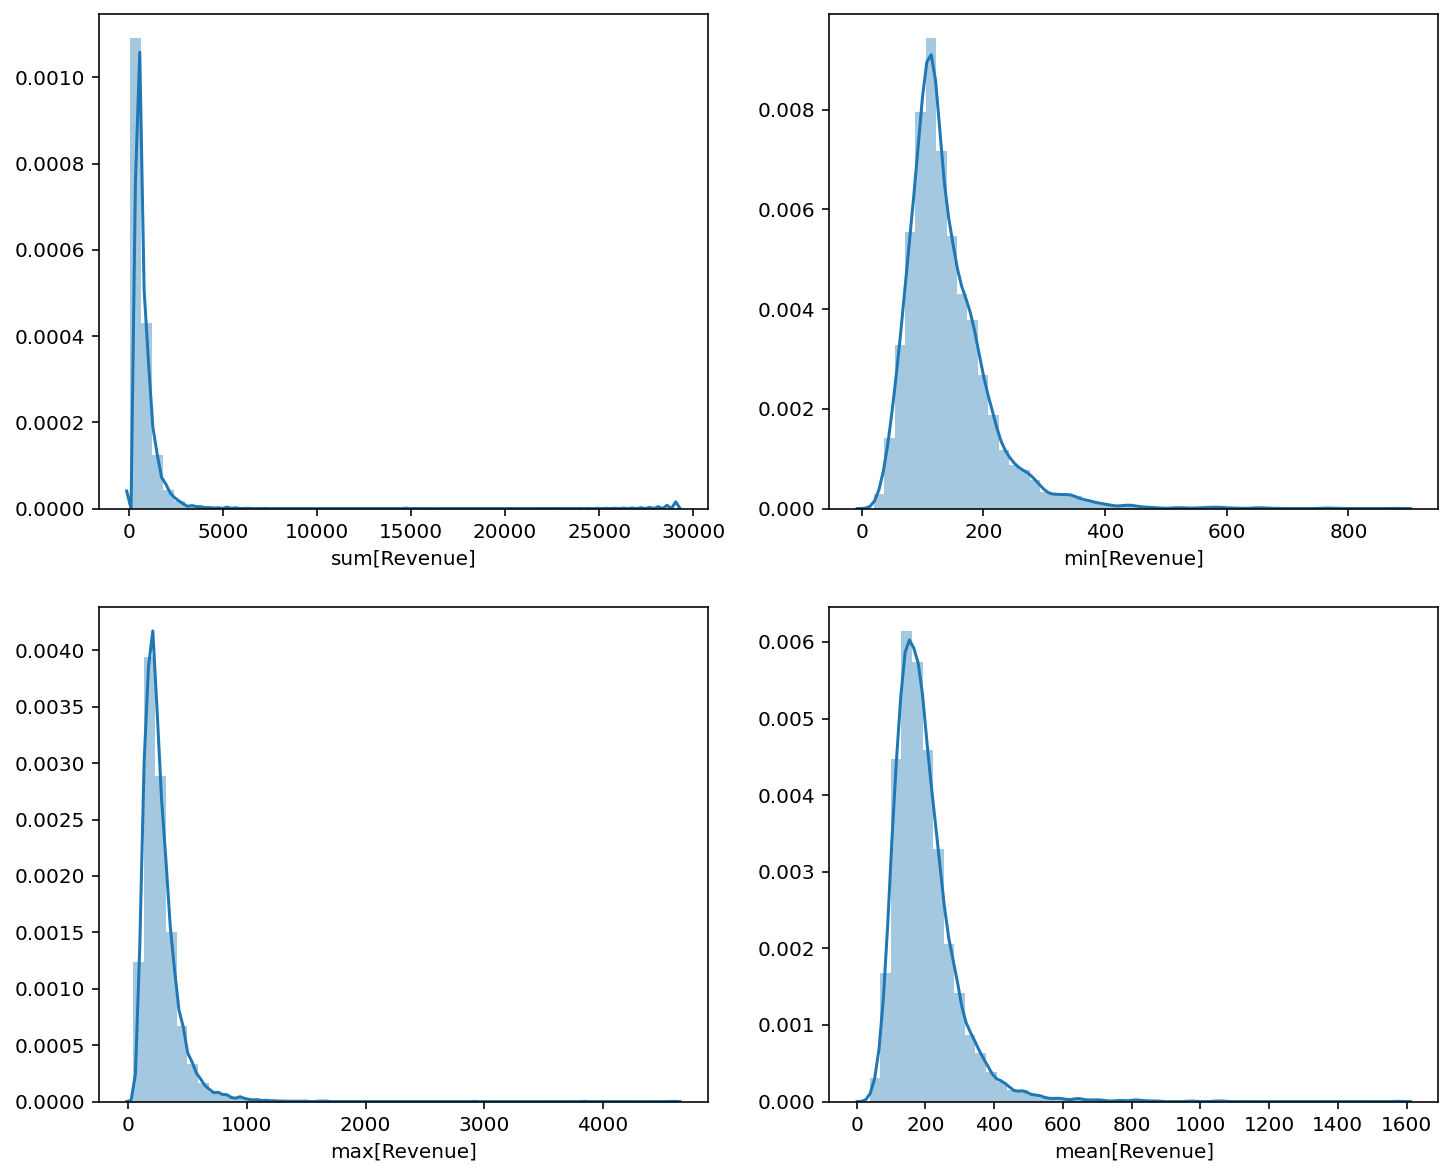

In [52]:
gross_table = df.dropna().groupby('User_ID').agg('count')
df_indexed = df.dropna().set_index('User_ID')
df_return = df_indexed.loc[gross_table.loc[(gross_table.Conv_ID > 1),:].index, :]
multiple_aggregation(df_return, 'Revenue', 'User_ID', aggs)

Compare with revenue, which also included customers who did only one transaction, the revenue of return customers has key differences:
* Mean and max values of return customers of revenue are higher than mean and max values of the general sample
* Kurtosis and skewness are lower for the return customers, meaning that the behaviour and predictions related to revenue are more robust. 

This comparison between the revenue of the general sample and sample of return customers shows the importance to take into account the loyalty KPIs of customers rather than only KPIs related to absolute values.



# Diagnostic analytics and elements of predictive analytics

## Perfomance and impact of channels over time:

In [53]:
df.groupby(pd.Grouper(key='Conv_Date', freq='M')).describe()

Revenue                                  ... IHC_Conv_V                    
             count        mean         std     min  ...        25%  50%  75%       max
Conv_Date                                           ...                               
2017-03-31  4966.0  192.716560  135.880636  20.000  ...        0.0  0.0  0.0  0.000000
2017-04-30  9066.0  226.305711  152.216189  24.000  ...        0.0  0.0  0.0  0.000000
2017-05-31  4783.0  160.282265   96.456488  35.640  ...        0.0  0.0  0.0  0.000000
2017-06-30  5495.0  175.267983   92.666923  30.664  ...        0.0  0.0  0.0  0.000000
2017-07-31  6031.0  170.050008   97.010634  33.220  ...        0.0  0.0  0.0  0.000000
2017-08-31  4865.0  159.089229   89.323212  29.628  ...        0.0  0.0  0.0  0.000000
2017-09-30  6852.0  179.542392  123.605985  29.924  ...        0.0  0.0  0.0  0.000000
2017-10-31  6748.0  188.326630   94.845753  32.956  ...        0.0  0.0  0.0  0.000000
2017-11-30  7988.0  177.394255   88.781460  32.508  ...        0.0  0.0  0.0  0.000000
2017-12-31  4997.0  175.365751   91.165198  32.908  ...        0.0  0.0  0.0  0.000000
2018-01-31  6049.0  172.893256   96.922619  27.532  ...        0.0  0.0  0.0  0.549986
2018-02-28  6019.0  178.525506   95.181849  28.532  ...        0.0  0.0  0.0  0.577486
2018-03-31  5756.0  176.007919   97.288425  27.532  ...        0.0  0.0  0.0  1.000000

[13 rows x 184 columns]

Detailed review with graphics of channels' perfomance over time is in the Tableau workbook.

The impact of the channels could be understand as a measure of characteristics of channels(in our case IHC_Conv) on some KPI. For basic KPI consider revenue over time. Evaluation of such impact could be coefficients in a linear regression, where independent variables are values IHC_Conv and dependent variable is the revenue.

For modeling using linear regression model several prequisites have to be met:
* Linearity(multicollinearity)(there is exist linear dependecy between an endogenous variable and exogenous variables). The exogenous variables at the same shouldn't have collinearity(on practice try to avoid at least strong collinearity).
* Homoscedasticity: $ Cov(\epsilon) = \sigma^2I$(const). Meaning that we don't want to have increasing in error over time.
* Absence of correlated errors: $ E(\epsilon_{i}) = 0. $ Otherwise, the evalution of coefficient would be shifted. 
* Normality. It is important during statistical testing(t-test, F-test..)

Firstly consider histogramm of the Revenue and corresponding Q-Q plot: 

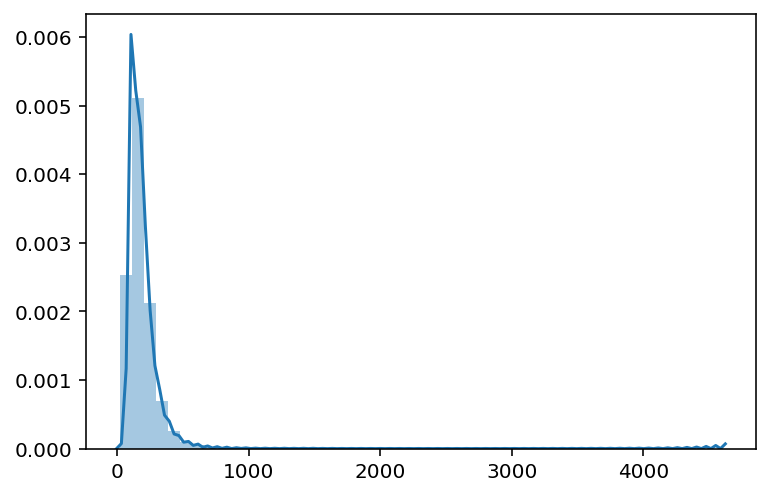

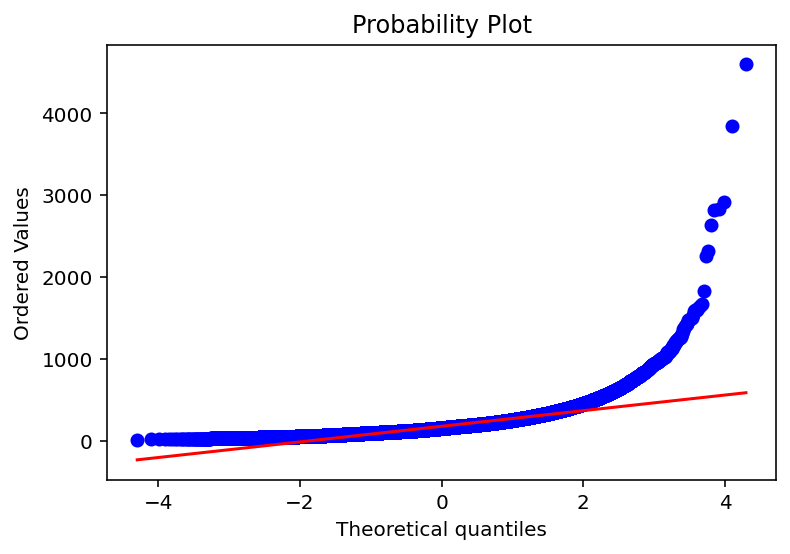

In [54]:
y = df.Revenue.values
sns.distplot(y, bins=50)
fig = plt.figure()
res = st.probplot(y, plot=plt)
plt.show()

As we can see from histogramm that the distribution of Revenue across all transactions is strongly skewed to right. The Q-Q plot shows that the sample in range(-4 quantile; 2 quantile) could be described by normal distribution. 

Try to make the distribution of the revenue to be more likely as normal distribution with log transformation:

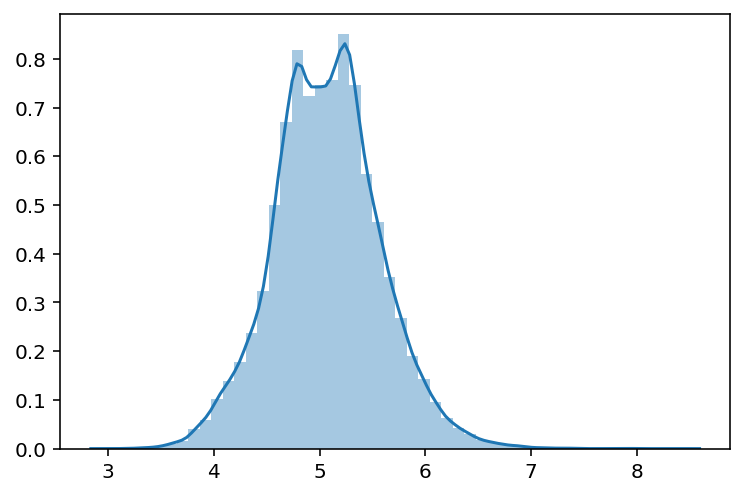

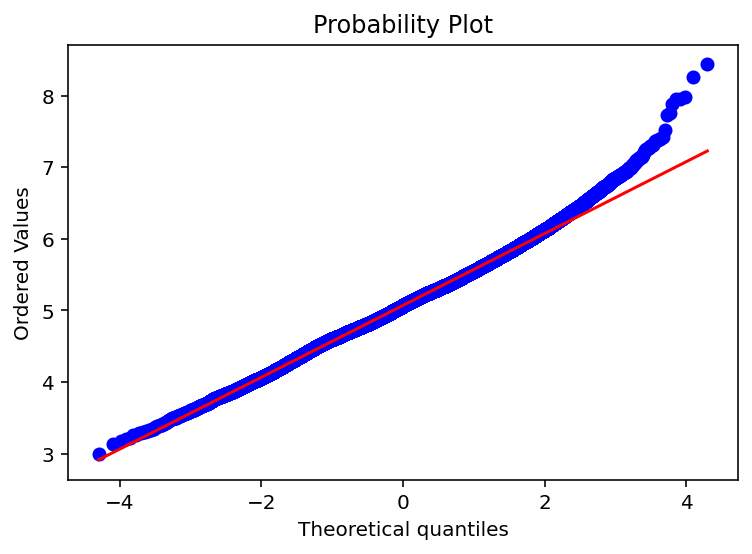

In [55]:
log_y = np.log(y)
sns.distplot(log_y, bins=50)
fig = plt.figure()
res = st.probplot(log_y, plot=plt)
plt.show()

Successfully we obtain better results, and now this distribution better looks like a normal distribution. 

Other assumption could be checked after evaluation of linear regression.

In [56]:
import statsmodels.api as sm

In [57]:
X = df.iloc[:, 4:].values

model_ols = sm.OLS(log_y, X).fit()
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          3.817e+05
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                        0.00
Time:                        16:43:40   Log-Likelihood:                         -56782.
No. Observations:               79615   AIC:                                  1.136e+05
Df Residuals:                   79593   BIC:                                  1.138e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

* From the results of Durbin-Watson test we observe that a hypothesis of absesence of autocorrelations between residuals do not rejected(since Durbin-Watson values around 2).
* Unfortunately, both tests(Omnibus and Jarque-Bera) checking normality of residuals shows that residuals are non-normal distributed(since p-value are about zero, meaning that we can reject null hypothesis without big probability to get 1st oder failure(to accept wrong hypothesis)). It means that exogeneous variables(in our case IHC_Conv of some channel) distributed non-normally.

Do additionaly Breusch-Pagan test to be sure in Homoscedasticity of residuals:

In [58]:
print('p-values of Breush-Pagan test = ',
      sm.stats.diagnostic.het_breuschpagan(model_ols.resid, X)[1])

p-values of Breush-Pagan test =  0.0


In [59]:
len(model_ols.resid)

79615

Based on the p-values statistics we can reject null hypothesis on a 0.01 level of confidence, meaning that there is heteroscedasticity in residuals. Take a look at the standardized residuals over time. In order to plot a representative graph(number of residuals - 79615, while time dates - only 396) we will aggragate all residuals by Conv_Date and for each date calculate mean value of standartized_residuals:

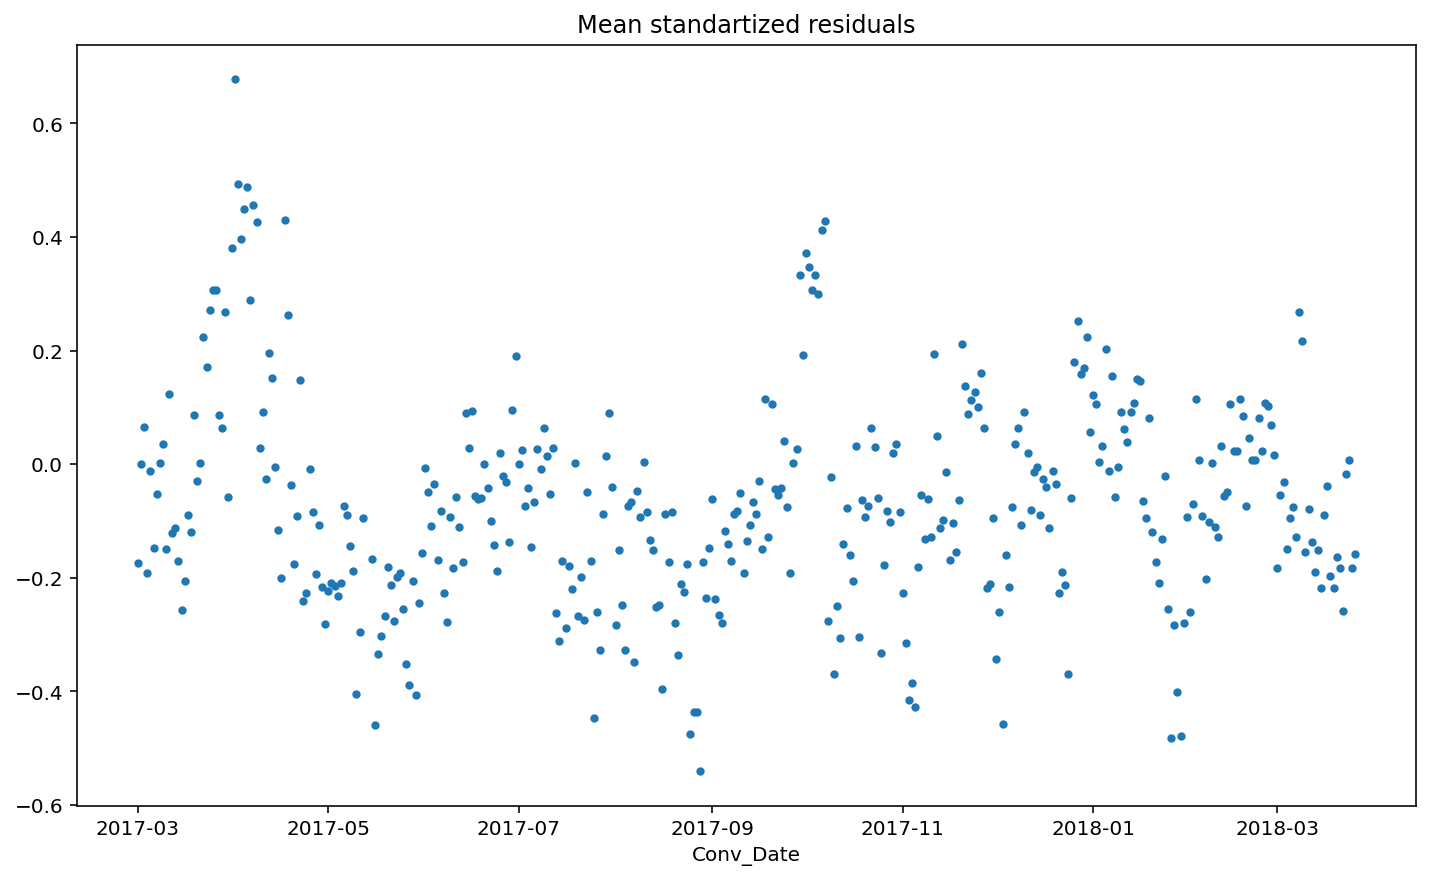

In [60]:
influence = model_ols.get_influence()
stnad_residuals = influence.resid_studentized_internal
table_residuals = pd.DataFrame(np.array([stnad_residuals, df.Conv_Date]).T, 
                               columns=['standartized_residuals','Conv_Date'])
table_residuals.standartized_residuals = table_residuals.standartized_residuals.astype(float)

plt.figure(figsize=(12,7))
plt.scatter(table_residuals.groupby('Conv_Date').agg('mean').index.values, 
            table_residuals.groupby('Conv_Date').agg('mean'), s=10)
plt.title('Mean standartized residuals')
plt.xlabel('Conv_Date')
plt.show()

As we can see, mean values of residuals are distributed not randomly(i.e. not like white noise) but have wave structure, meaning that variance depends on values of revenue. Therefore, values of IHC_Conv from channels is more volatile, when a number of transactions are bigger and vice versa. It could be explained quite intuitively, the bigger number of customers make transactions, the bigger would be differences between their sum of transactions. 

Under heteroscedasticity conditions effective evaluations of coefficients, standard deviation and trustfull test statistics could be obtained by applying robust estimations of covariance matrix:

In [61]:
model_ols2 = sm.OLS(log_y, X).fit(cov_type='HC1')
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          3.817e+05
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                        0.00
Time:                        16:43:42   Log-Likelihood:                         -56782.
No. Observations:               79615   AIC:                                  1.136e+05
Df Residuals:                   79593   BIC:                                  1.138e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

So now we have trustful evaluations of coefficients and test statics:
* Adj. R-squared = 0.991 meaning that 99.1% of variance could be explained by a model(good model)
* F-statistic < 1.96, meaning that the we can reject hypothesis, that all coefficients of the model are equal to 0.
* All p-values of coefficients are zeros => all coefficients are statistical significant

As a measure of channel importance could be considered as a values of a coefficient of the corresponding channels. The coefficients sorted in a descending order: 

In [62]:
table_coef = pd.DataFrame([model_ols2.params], columns=np.ravel(df.iloc[:, 4:].columns))
table_coef.sort_values(axis=1, by=0, ascending=False)

,IHC_Conv_T,IHC_Conv_A,IHC_Conv_C,IHC_Conv_E,IHC_Conv_B,IHC_Conv_S,IHC_Conv_G,IHC_Conv_J,IHC_Conv_H,IHC_Conv_F,IHC_Conv_I,IHC_Conv_R,IHC_Conv_D,IHC_Conv_N,IHC_Conv_V,IHC_Conv_M,IHC_Conv_O,IHC_Conv_U,IHC_Conv_K,IHC_Conv_L,IHC_Conv_Q,IHC_Conv_P
0,5.316039,5.157342,5.145468,5.132921,5.096687,5.085583,5.075414,5.046628,5.036309,5.027596,5.013541,5.013053,4.977541,4.94434,4.940842,4.835644,4.828686,4.809273,4.724077,4.520435,4.407391,4.33198


## Customer segmentation

Before customer segmentation, it is vital to determine the characteristics of customers, based on which would be useful to make customer segmentation. Customer segmentation is mostly important for group separation, where objects(in our case customers) are similar to each other based on some metrics. This group separation could be used further for building classification or predictive algorithms on each group separately. Therefore the quality of these algorithms should be higher than the quality of algorithm on a general sample.

From the previous steps of analysis and from the list of KPIs, we conclude that the most important features for distigusiging customers between groups are:

* The mean revenue of transaction
* Number of transactions
* Mean value of IHC for each channel
* Number of days between first transaction and the last transaction(for those who bought a product only once this value is 0)

### Preprocessing data for clustering:

In [64]:
grouper = df.dropna().groupby('User_ID')
df_clust = pd.DataFrame(pd.unique(df.dropna()['User_ID']).T, columns=['User_ID'])

In [65]:
# The mean revenue of transaction:
df_clust['Mean revenue'] = grouper.agg('mean')['Revenue'].values

In [66]:
# The number of transactions:
df_clust['n_transactions'] = grouper.agg('count')['Conv_ID'].values

In [67]:
# Mean value of IHC for each channel:
df_clust = df_clust.merge(grouper.agg('mean').iloc[:,1:], on='User_ID')

In [68]:
# Column of difference between first transaction and last transaction:
df_clust['DiffTransactions'] = ((grouper.agg('max')['Conv_Date'].values - grouper.agg('min')['Conv_Date'].values)
                                 /np.timedelta64(1, 'D')).astype('int')

In [69]:
df_clust

,User_ID,Mean revenue,n_transactions,IHC_Conv_A,IHC_Conv_B,IHC_Conv_C,IHC_Conv_D,IHC_Conv_E,IHC_Conv_F,IHC_Conv_G,IHC_Conv_H,IHC_Conv_I,IHC_Conv_J,IHC_Conv_K,IHC_Conv_L,IHC_Conv_M,IHC_Conv_N,IHC_Conv_O,IHC_Conv_P,IHC_Conv_Q,IHC_Conv_R,IHC_Conv_S,IHC_Conv_T,IHC_Conv_U,IHC_Conv_V,DiffTransactions
0,5094298f068196c5349d43847de5afc9125cf989,153.840,1,0.332806,0.114196,0.000000,0.0,0.009662,0.0,0.243896,0.106291,0.161051,0.0,0.000000,0.024554,0.007543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,122.816,2,0.324014,0.058348,0.000000,0.0,0.010324,0.0,0.128455,0.267891,0.210920,0.0,0.000048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53
2,59853624ad85789cc5c865405e741c612da334da,416.582,2,0.465723,0.000000,0.000000,0.0,0.000000,0.0,0.160139,0.124138,0.250000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,121.808,1,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,108.720,1,0.052091,0.000000,0.151465,0.0,0.000000,0.0,0.401703,0.000000,0.394741,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55327,33dd250f3455918ce68e0d77036fbdcde856b4c6,97.336,1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
55328,6836d8cdd9c6c537c702b35ccd972fae58070004,148.144,1,0.518424,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.481576,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
55329,39b5fdd28cb956053d3e4f3f0b884fb95749da8a,210.800,1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
55330,3342d5b210274b01e947cc15531ad53fbe25435b,84.628,1,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79615 entries, 0 to 79614
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Conv_Date   79615 non-null  datetime64[ns]
 1   Revenue     79615 non-null  float64       
 2   User_ID     77319 non-null  object        
 3   Conv_ID     79615 non-null  object        
 4   IHC_Conv_A  79615 non-null  float64       
 5   IHC_Conv_B  79615 non-null  float64       
 6   IHC_Conv_C  79615 non-null  float64       
 7   IHC_Conv_D  79615 non-null  float64       
 8   IHC_Conv_E  79615 non-null  float64       
 9   IHC_Conv_F  79615 non-null  float64       
 10  IHC_Conv_G  79615 non-null  float64       
 11  IHC_Conv_H  79615 non-null  float64       
 12  IHC_Conv_I  79615 non-null  float64       
 13  IHC_Conv_J  79615 non-null  float64       
 14  IHC_Conv_K  79615 non-null  float64       
 15  IHC_Conv_L  79615 non-null  float64       
 16  IHC_Conv_M  79615 non-

For clustering I will use most popular algorithms: K-means, Hierarchical clustering and DBSCAN.

Before the clustering visualize the data on 2 dimensional graph using t-distributed Stochastic Neighbor Embedding:

In [72]:
from sklearn import manifold

In [ ]:
# will took very much time!!
X = df_clust.iloc[:, 1:]
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 10, n_jobs=-1)
data_2d_tsne = tsne.fit_transform(X)

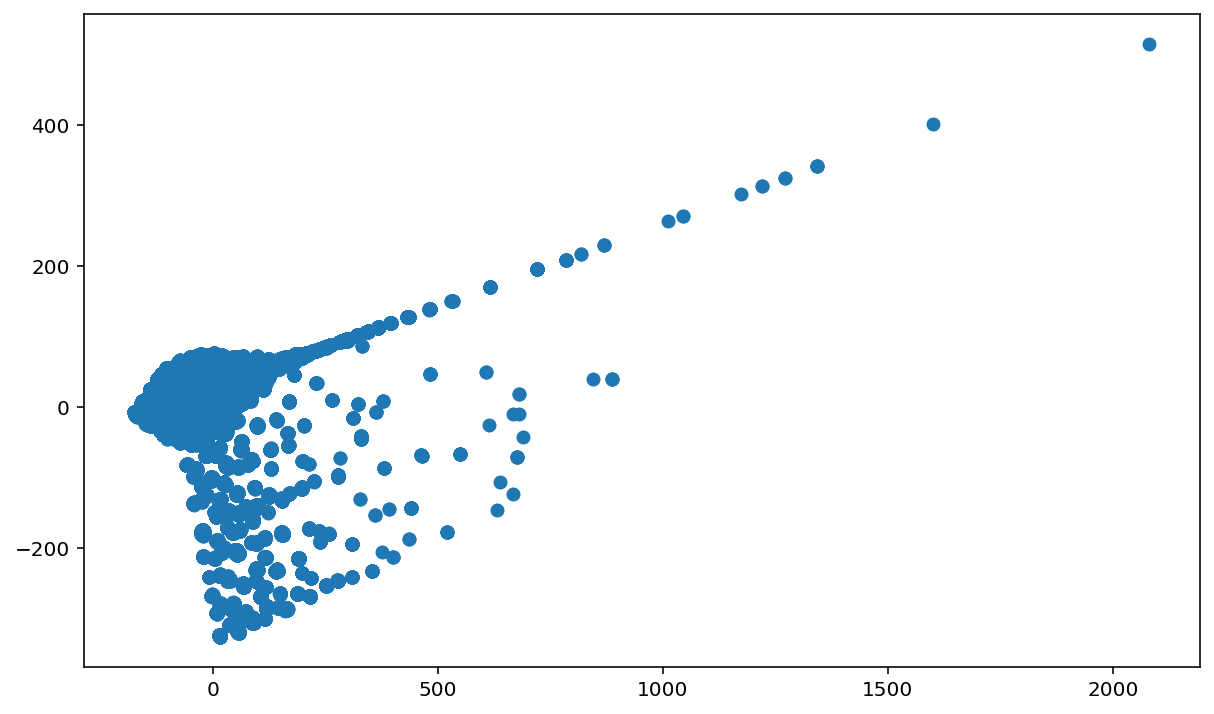

In [75]:
plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1])
plt.show()

### K-means:

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler

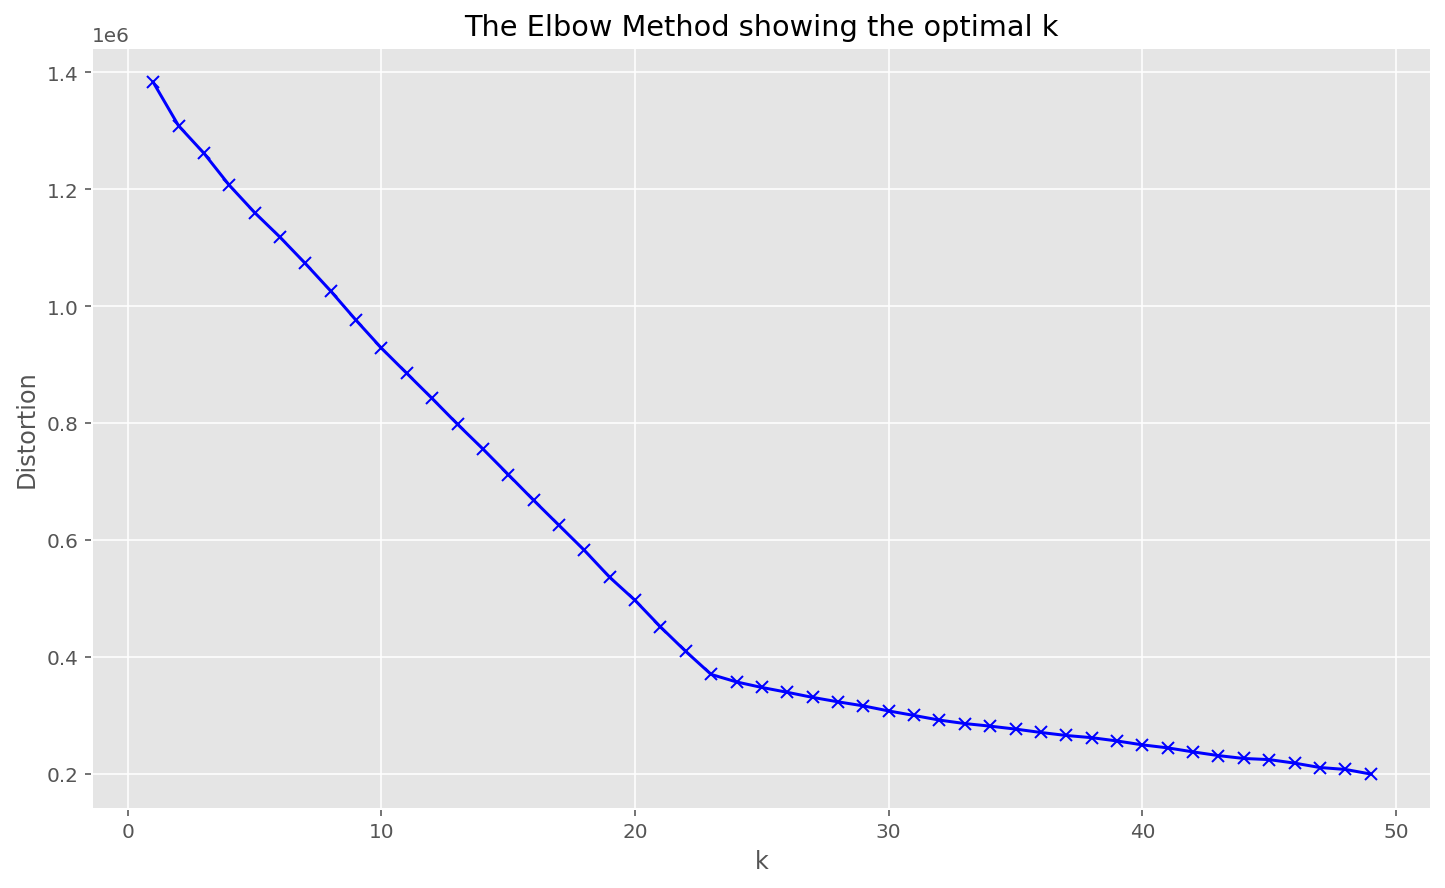

In [77]:
# calculations might took a time!
distortions = []
# Standatised features for getting better results:
X = StandardScaler().fit_transform(X)

K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=10)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(12,7))
plt.style.use('ggplot')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

According to elbow plot a sufficient number of cluster is achieved about 22, 23 cluster. For determining optimal value k plot the Silhouette coefficient and look at the cluster size and the value range of Silhouette coefficient inside cluster using convinient visualization:

For n_clusters = 22 The average silhouette_score is : 0.32711801081446
For n_clusters = 23 The average silhouette_score is : 0.3475731998954339


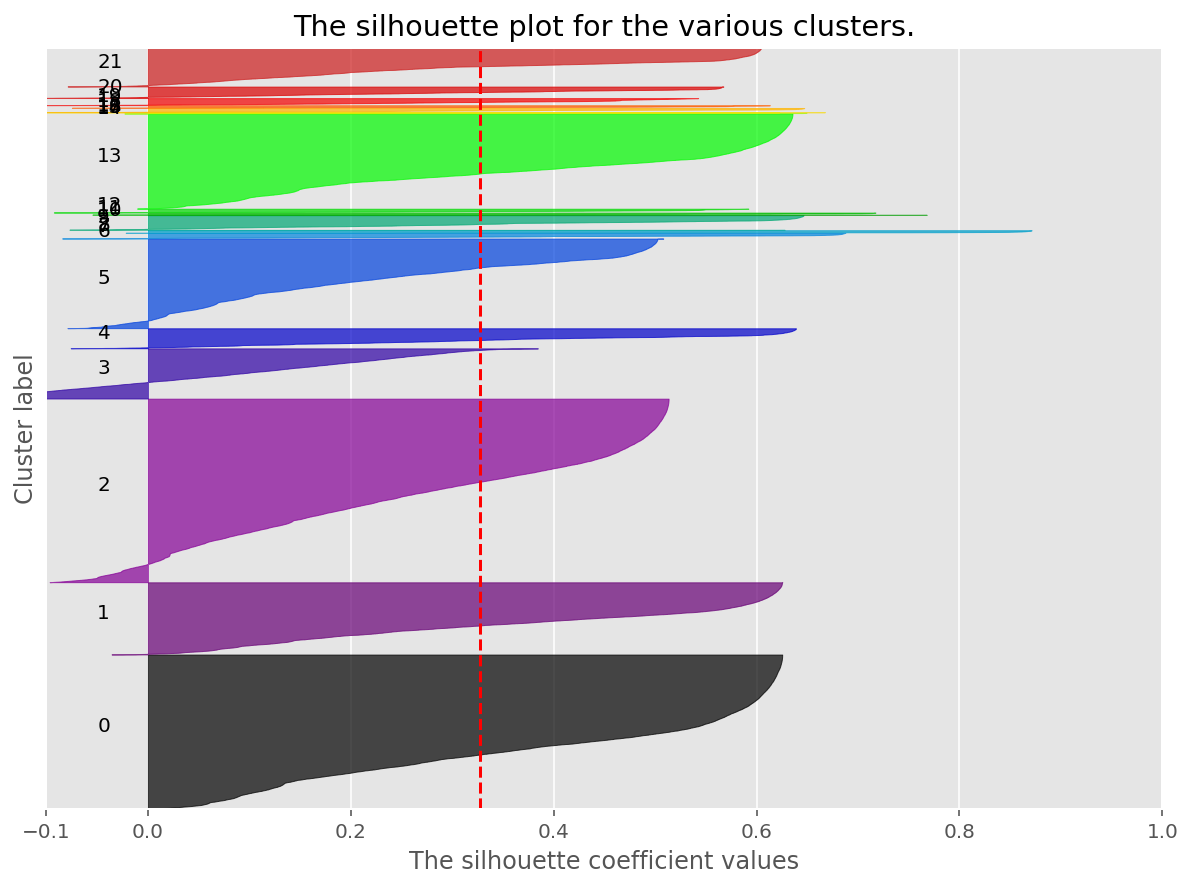

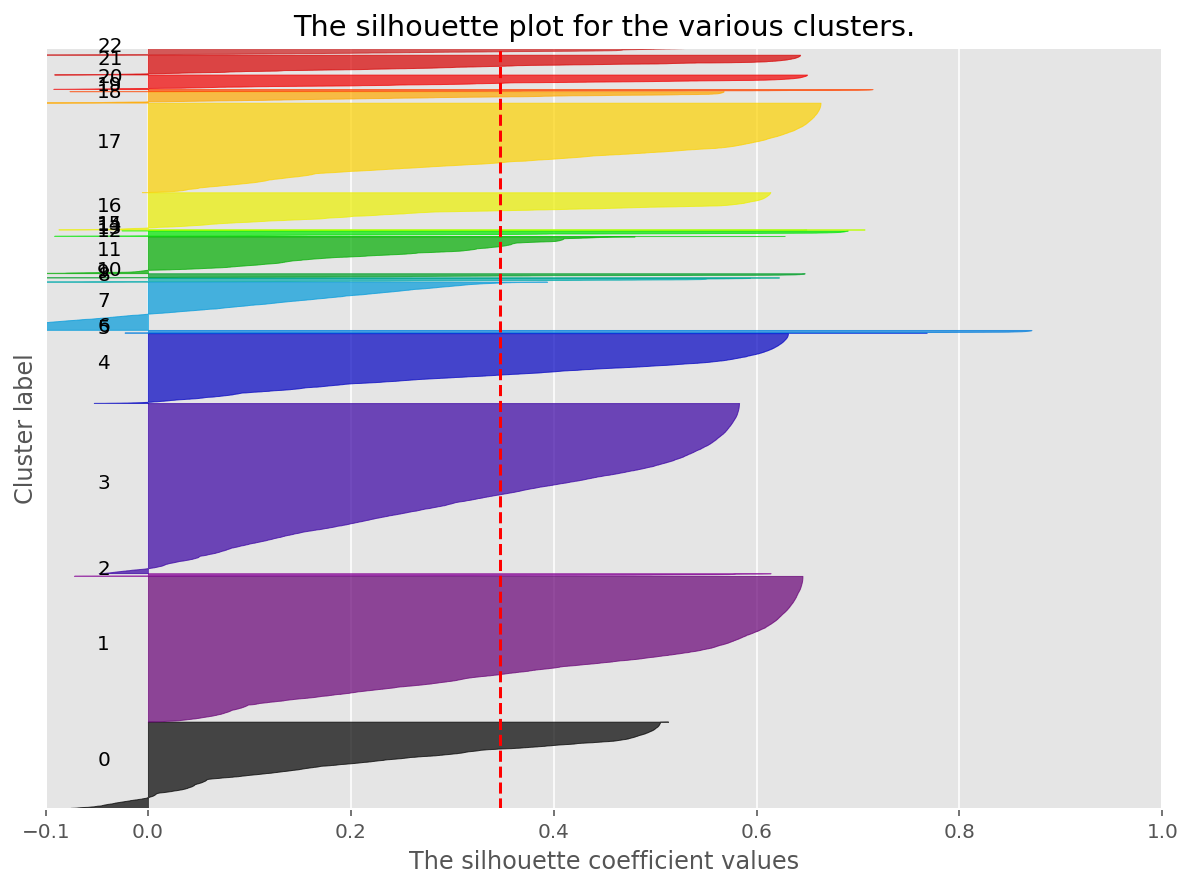

In [80]:
range_n_clusters = [22, 23]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.figure(), plt.axes()
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Based on this visualizations - 23 clusters seemed better, because intracluster distance is less(silhouette_score is more) and the classes looks more equally. Visualization of clusters:

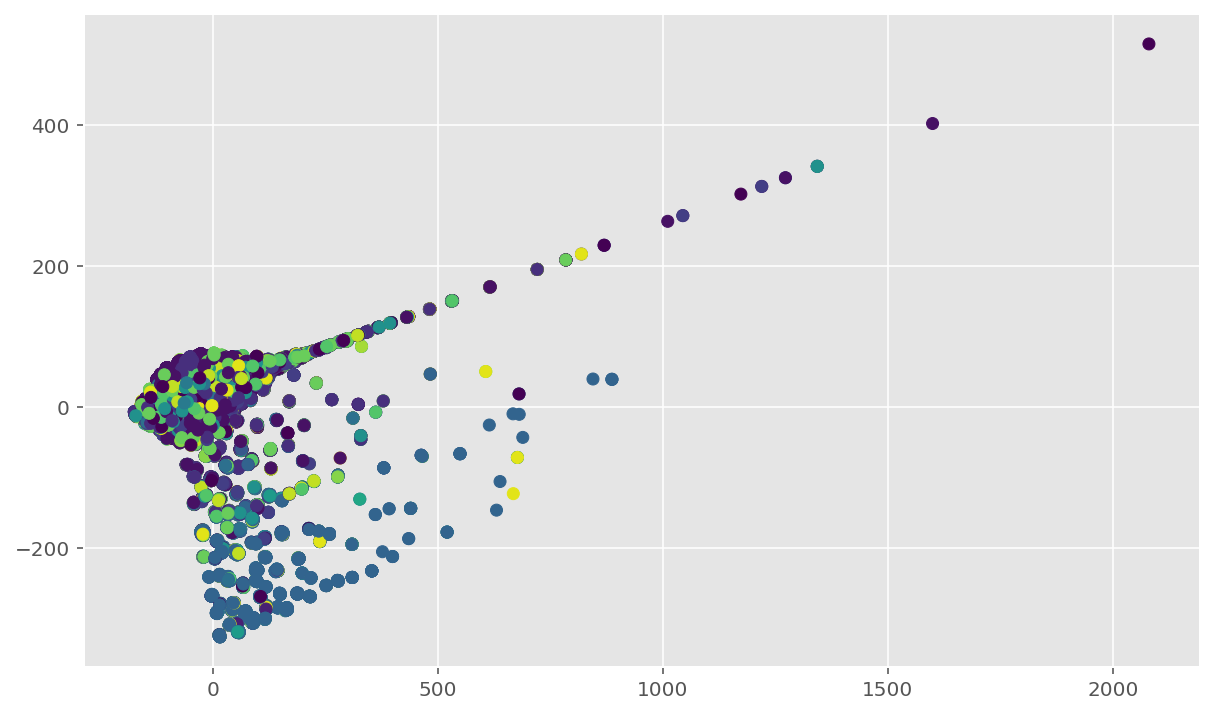

In [82]:
kmeanModel_optimal = KMeans(n_clusters=23, random_state=10)
kmeanModel_optimal.fit(X)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=kmeanModel_optimal.labels_)
plt.show()

Using algorithm of clustering based on density DBSCAN

### DBSCAN:

In [83]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Firstly determine the hyperparameter for the algorithm eps, which represents the maximum distance between two points, using NearestNeighbour cluster algorithm.

In [84]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

Next, we sort and plot results. The optimal value for epsilon will be found at the point of maximum curvature.

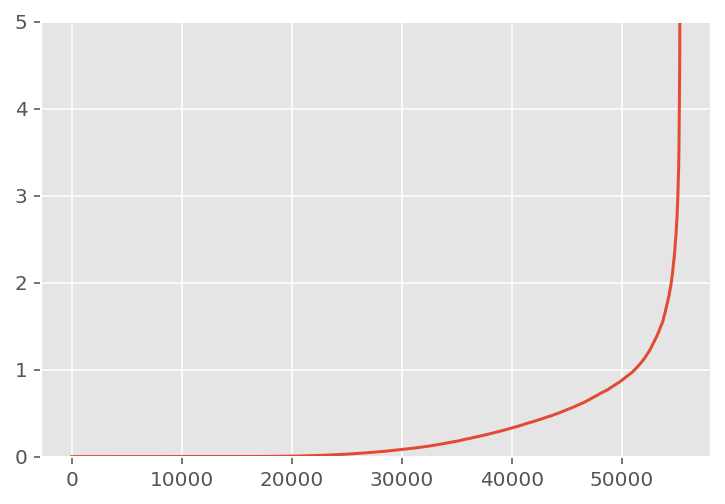

In [85]:
distances = np.sort(distances, axis=0)
distances1 = distances[:,1]
plt.plot(distances1)
plt.ylim(0, 5)
plt.show()

Maximum curvature of the plot is about eps=1

In [86]:
dbscan_optimal = DBSCAN(eps=1)
dbscan_optimal.fit(X)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

Visualization of clusters from DBSCAN algorithm:

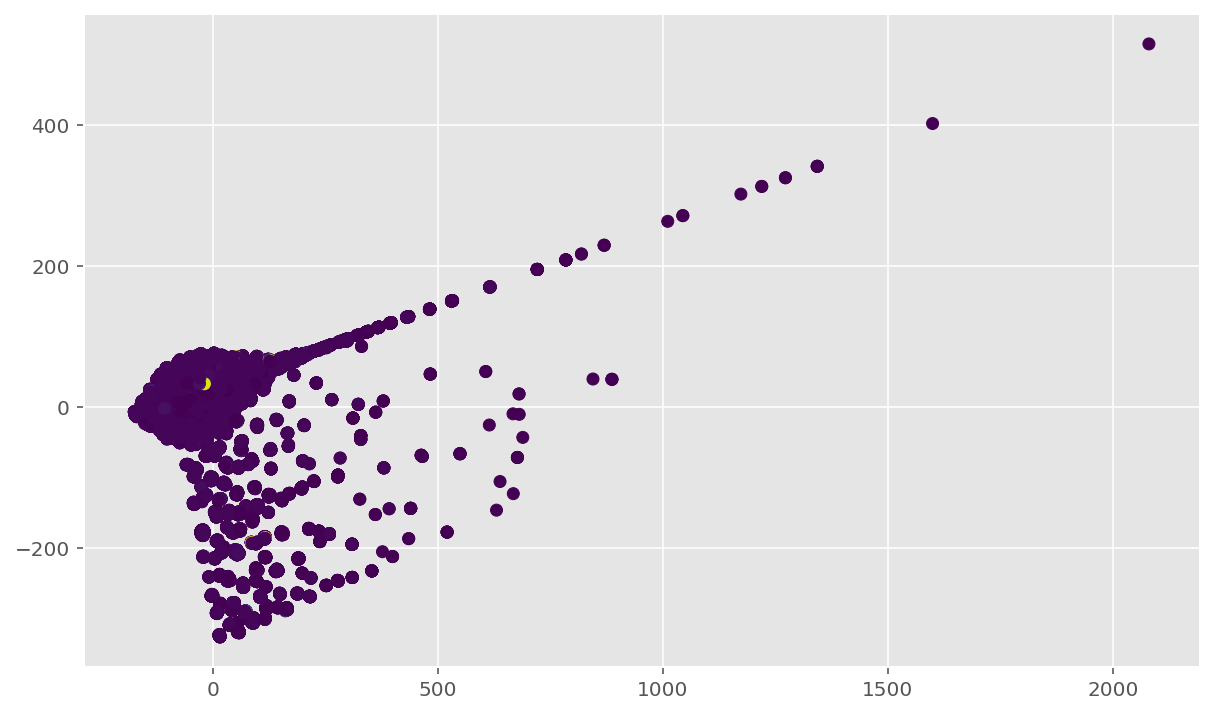

In [87]:
plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=dbscan_optimal.labels_)
plt.show()

Number of clusters that DBSCAN was able to determine:

In [92]:
len(set(dbscan_optimal.labels_)) - 1

71

Number of abnormal values DBSCAN assign to -1 clusters

In [93]:
np.sum(dbscan_optimal.labels_ == -1)

5914

In [106]:
values, counts = np.unique(dbscan_optimal.labels_, return_counts=True)
dict(zip(values, counts))

{-1: 5914,
 0: 47295,
 1: 422,
 2: 237,
 3: 7,
 4: 198,
 5: 175,
 6: 15,
 7: 42,
 8: 28,
 9: 16,
 10: 140,
 11: 6,
 12: 58,
 13: 7,
 14: 5,
 15: 17,
 16: 7,
 17: 111,
 18: 8,
 19: 8,
 20: 22,
 21: 9,
 22: 13,
 23: 38,
 24: 7,
 25: 9,
 26: 14,
 27: 5,
 28: 47,
 29: 9,
 30: 9,
 31: 15,
 32: 9,
 33: 5,
 34: 10,
 35: 5,
 36: 11,
 37: 16,
 38: 9,
 39: 21,
 40: 6,
 41: 8,
 42: 11,
 43: 21,
 44: 10,
 45: 5,
 46: 11,
 47: 5,
 48: 8,
 49: 11,
 50: 5,
 51: 5,
 52: 6,
 53: 5,
 54: 4,
 55: 6,
 56: 5,
 57: 4,
 58: 4,
 59: 8,
 60: 5,
 61: 40,
 62: 56,
 63: 37,
 64: 6,
 65: 8,
 66: 10,
 67: 8,
 68: 6,
 69: 6,
 70: 3}

### Inserting results of clustering algorithms to the table:


In [109]:
df_clust['Kmean_labels'] = kmeanModel_optimal.labels_
df_clust['DBSCAN_labels'] = dbscan_optimal.labels_

In [110]:
df_clust

,User_ID,Mean revenue,n_transactions,IHC_Conv_A,IHC_Conv_B,IHC_Conv_C,IHC_Conv_D,IHC_Conv_E,IHC_Conv_F,IHC_Conv_G,IHC_Conv_H,IHC_Conv_I,IHC_Conv_J,IHC_Conv_K,IHC_Conv_L,IHC_Conv_M,IHC_Conv_N,IHC_Conv_O,IHC_Conv_P,IHC_Conv_Q,IHC_Conv_R,IHC_Conv_S,IHC_Conv_T,IHC_Conv_U,IHC_Conv_V,DiffTransactions,Kmean_labels,DBSCAN_labels
0,5094298f068196c5349d43847de5afc9125cf989,153.840,1,0.332806,0.114196,0.000000,0.0,0.009662,0.0,0.243896,0.106291,0.161051,0.0,0.000000,0.024554,0.007543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,122.816,2,0.324014,0.058348,0.000000,0.0,0.010324,0.0,0.128455,0.267891,0.210920,0.0,0.000048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,3,0
2,59853624ad85789cc5c865405e741c612da334da,416.582,2,0.465723,0.000000,0.000000,0.0,0.000000,0.0,0.160139,0.124138,0.250000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237,7,-1
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,121.808,1,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,108.720,1,0.052091,0.000000,0.151465,0.0,0.000000,0.0,0.401703,0.000000,0.394741,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55327,33dd250f3455918ce68e0d77036fbdcde856b4c6,97.336,1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,17,0
55328,6836d8cdd9c6c537c702b35ccd972fae58070004,148.144,1,0.518424,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.481576,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
55329,39b5fdd28cb956053d3e4f3f0b884fb95749da8a,210.800,1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
55330,3342d5b210274b01e947cc15531ad53fbe25435b,84.628,1,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11,2
